In [ ]:
from abc import ABC, abstractmethod

from matplotlib import backends
import torch
import torch.nn as nn
import torch.nn.functional as F

class SiameseNetworkBase(ABC):
    @abstractmethod
    def __init__(self, image_size, color_channels, embedding_size):
        pass

    @abstractmethod
    def forward_once(self, x):
        pass

    @abstractmethod
    def forward(self, input1, input2):
        pass

    @abstractmethod
    def compute_embedding(self, x):
        pass

    @abstractmethod
    def save_model(self, filepath):
        pass

    @abstractmethod
    def load_model(self, filepath):
        pass

class SiameseNetworkPyTorch(SiameseNetworkBase, nn.Module):
    def __init__(self, image_size=(105, 105), color_channels=1, embedding_size=128):
        nn.Module.__init__(self)
        SiameseNetworkBase.__init__(self, image_size, color_channels, embedding_size)
        self.image_size = image_size
        self.color_channels = color_channels
        self.embedding_size = embedding_size
        self.transform = None

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.color_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        # Calculate the size after convolutional layers to define the first linear layer
        self._to_linear = self._calculate_conv_output_size()

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 4096),
            nn.ReLU(),
            nn.Linear(4096, self.embedding_size)
        )

        # Initialize weights
        self._initialize_weights()

    def _calculate_conv_output_size(self):
        # Dummy input to calculate the size
        with torch.no_grad():
            #print(f"Calculating the size after convolutional layers... (input size: {self.color_channels}x{self.image_size[0]}x{self.image_size[1]})")
            x = torch.zeros(1, self.color_channels, *self.image_size)
            x = self.conv_layers(x)
            return x.view(1, -1).size(1)

    def forward_once(self, x):
        #print(x.shape)
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1)  # Flatten
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    @staticmethod
    def load_trained_model(filepath, image_size=(105, 105), color_channels=3, embedding_size=128):
        """
        Loads a trained Siamese network from a saved state dict.

        Args:
            filepath (str): Path to the saved model file.
            image_size (tuple): Size of the input images.
            color_channels (int): Number of color channels.
            embedding_size (int): Size of the embedding vector.

        Returns:
            SiameseNetworkPyTorch: An instance of the loaded model.
        """
        model = SiameseNetworkPyTorch(
            image_size=image_size,
            color_channels=color_channels,
            embedding_size=embedding_size
        )
        model.load_model(filepath)
        model.eval()
        return model

    def predict(self, img1, img2, transform, threshold):
        """
        Predicts whether two images are similar or dissimilar.

        Args:
            img1 (PIL.Image or str): First image or path to the image.
            img2 (PIL.Image or str): Second image or path to the image.
            transform (callable): Transformations to apply to the images.
            threshold (float): Threshold for determining similarity.

        Returns:
            float: The Euclidean distance between the embeddings.
            int: Prediction label (0 for similar, 1 for dissimilar).
        """
        # Load images if paths are provided
        if isinstance(img1, str):
            img1 = Image.open(img1).convert('RGB')
        if isinstance(img2, str):
            img2 = Image.open(img2).convert('RGB')

        # Apply transformations
        img1 = transform(img1).unsqueeze(0)  # Add batch dimension
        img2 = transform(img2).unsqueeze(0)

        # Move to device
        device = next(self.parameters()).device
        img1 = img1.to(device)
        img2 = img2.to(device)

        # Compute embeddings
        with torch.no_grad():
            output1 = self.forward_once(img1)
            output2 = self.forward_once(img2)

        # Compute Euclidean distance
        #euclidean_distance = F.pairwise_distance(output1, output2).item()
        cosine_similarity = F.cosine_similarity(output1, output2).item()

        # Make prediction based on threshold
        #prediction = 1 if euclidean_distance > threshold else -1
        prediction = 1.0 if cosine_similarity >= threshold else -1.0

        #return euclidean_distance, prediction
        return cosine_similarity, prediction

    def compute_embedding(self, img, transform):
        """
        Computes the embedding for a single image.

        Args:
            img (PIL.Image or str): Image or path to the image.
            transform (callable): Transformations to apply to the image.

        Returns:
            Tensor: Embedding vector.
        """
        # Load image if path is provided
        if isinstance(img, str):
            img = Image.open(img).convert('RGB')

        # Apply transformations
        img = transform(img).unsqueeze(0)  # Add batch dimension

        # Move to device
        device = next(self.parameters()).device
        img = img.to(device)

        # Compute embedding
        with torch.no_grad():
            embedding = self.forward_once(img)

        return embedding.cpu().numpy().flatten()

    def save_model(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load_model(self, filepath):
        self.load_state_dict(torch.load(filepath))

    def _initialize_weights(self):
        # Initialize weights using Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


from abc import ABC, abstractmethod
from torch.utils.data import Dataset

class SiameseDatasetBase(Dataset, ABC):
    def __init__(self, transform=None, callbacks=None):
        """
        Base class for Siamese datasets.

        Args:
            transform (callable, optional): Optional transform to be applied on a sample.
            callbacks (dict, optional): Dictionary of callback functions for data retrieval.
        """
        self.transform = transform
        self.callbacks = callbacks or {}

    @abstractmethod
    def __getitem__(self, index):
        pass

    @abstractmethod
    def __len__(self):
        pass

import os
import random
from PIL import Image
import torch

class SiameseDatasetFromPaths(SiameseDatasetBase):
    def __init__(self, image_folder_dataset, transform=None, num_pairs=10000):
        super().__init__(transform=transform)
        self.image_folder_dataset = image_folder_dataset
        self.classes = list(self.image_folder_dataset.keys())
        self.transform = transform

        # Precompute pairs
        self.pairs = []
        for _ in range(num_pairs):
            should_get_same_class = random.randint(0, 1)
            class1 = random.choice(self.classes)
            img1_path = random.choice(self.image_folder_dataset[class1])

            if should_get_same_class or len(self.classes) < 2:
                # Positive pair
                class2 = class1
                label = 1.0
            else:
                # Negative pair
                class2 = random.choice(self.classes)
                while class1 == class2:
                    class2 = random.choice(self.classes)
                label = -1.0

            img2_path = random.choice(self.image_folder_dataset[class2])
            self.pairs.append((img1_path, img2_path, label))

    def __getitem__(self, index):
        img1_path, img2_path, label = self.pairs[index]

        img1 = Image.open(img1_path).convert('L')
        img2 = Image.open(img2_path).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)
    
def build_image_dataset_from_directory(root_dir):
    """
    Builds a dictionary where each key is a class label and the value is a list of image paths.
    
    Args:
        root_dir (str): Path to the root directory ('train' or 'val').
    
    Returns:
        dict: A dictionary with class labels as keys and lists of image paths as values.
    """
    image_dataset = {}
    classes = os.listdir(root_dir)
    for cls in classes:
        cls_path = os.path.join(root_dir, cls)
        if os.path.isdir(cls_path):
            images = [os.path.join(cls_path, img) for img in os.listdir(cls_path)
                      if img.lower().endswith(('jpg', 'png', 'jpeg'))]
            if images:
                image_dataset[cls] = images
    return image_dataset

import torch
from PIL import Image
import numpy as np

class SiameseDatasetFromCpp(SiameseDatasetBase):
    def __init__(self, transform=None, callbacks=None):
        super().__init__(transform=transform, callbacks=callbacks)

        if 'get_data' not in self.callbacks:
            raise ValueError("Callback 'get_data' must be provided for SiameseDatasetFromCpp")

        # Optionally, initialize any required state or connection here
        # For example, establish a connection to the C++ application if needed

    def __getitem__(self, index):
        """
        Retrieves a data sample from the C++ application via the 'get_data' callback.

        Args:
            index (int): Index of the sample. Since data is provided via callback, index can be ignored.

        Returns:
            Tuple[Tensor, Tensor, Tensor]: Tuple containing the two images and the label.
        """
        # Fetch image data and label from the C++ application via the 'get_data' callback
        img1_data, img2_data, label = self.callbacks['get_data']()

        # Convert raw data to PIL Images
        img1 = Image.fromarray(img1_data).convert('RGB')
        img2 = Image.fromarray(img2_data).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label_tensor = torch.tensor([label], dtype=torch.float32)

        return img1, img2, label_tensor

    def __len__(self):
        """
        Returns the length of the dataset.

        Since data is provided on-demand from the C++ application, we can set an arbitrary large number
        or manage the length via a callback if needed.

        Returns:
            int: Length of the dataset.
        """
        if 'get_length' in self.callbacks:
            return self.callbacks['get_length']()
        else:
            # Return a large number to simulate an infinite dataset
            return 1000000
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive
    
# siamese_trainer.py

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import copy

from tqdm import tqdm

# Import or define your model and dataset classes here
# from siamese_network import SiameseNetworkPyTorch
# from contrastive_loss import ContrastiveLoss
# from siamese_dataset import SiameseDatasetFromPaths, SiameseDatasetFromCpp

class SiameseTrainer:
    @staticmethod
    def train_model(
        model_params,
        train_dataset_params,
        val_dataset_params,
        training_params,
        callbacks
    ):
        """
        Static method to train the Siamese network.

        Args:
            model_params (dict): Parameters for model initialization.
            train_dataset_params (dict): Parameters for the training dataset.
            val_dataset_params (dict): Parameters for the validation dataset.
            training_params (dict): Training parameters (epochs, batch_size, learning_rate, etc.).
            callbacks (dict): Dictionary of callback functions.
        """
        # Unpack model parameters
        image_size = model_params.get('image_size', (105, 105))
        color_channels = model_params.get('color_channels', 3)
        embedding_size = model_params.get('embedding_size', 128)

        # Unpack training parameters
        num_epochs = training_params.get('num_epochs', 10)
        batch_size = training_params.get('batch_size', 32)
        learning_rate = training_params.get('learning_rate', 0.0005)
        max_batches = training_params.get('max_batches', None)
        margin = training_params.get('margin', 2.0)
        threshold = training_params.get('threshold', 0.5) #margin / 2.0)
        patience = training_params.get('patience', 5)  # For early stopping
        device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

        # Define transformations
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*color_channels, std=[0.5]*color_channels)
        ])

        # Initialize the training dataset
        train_dataset_class = train_dataset_params.get('dataset_class', 'paths')
        if train_dataset_class == 'dataset':
            train_dataset = train_dataset_params.get('data')
        elif train_dataset_class == 'paths':
            train_dataset = SiameseDatasetFromPaths(train_dataset_params.get('data'), transform=transform)
        elif train_dataset_class == 'cpp':
            train_dataset = SiameseDatasetFromCpp(transform=transform, callbacks=callbacks)
        else:
            raise ValueError("Invalid train dataset_class specified.")

        # Initialize the validation dataset
        val_dataset_class = val_dataset_params.get('dataset_class', 'paths')
        if val_dataset_class == 'dataset':
            val_dataset = val_dataset_params.get('data')
        elif val_dataset_class == 'paths':
            val_dataset = SiameseDatasetFromPaths(val_dataset_params.get('data'), transform=transform)
        elif val_dataset_class == 'cpp':
            val_dataset = SiameseDatasetFromCpp(transform=transform, callbacks=callbacks)
        else:
            raise ValueError("Invalid val dataset_class specified.")

        # DataLoaders
        train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)
        val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=0)

        # Initialize the model
        print(f"Training on {device}, with {color_channels} color channels")
        model = SiameseNetworkPyTorch(
            image_size=image_size,
            color_channels=color_channels,
            embedding_size=embedding_size
        )
        model.transform = transform  # Store the transform for later use
        model = model.to(device)

        # Loss function and optimizer
        #criterion = ContrastiveLoss(margin=margin)
        criterion = torch.nn.CosineEmbeddingLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Learning Rate Scheduler
        from torch.optim.lr_scheduler import ReduceLROnPlateau
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

        # Early stopping parameters
        best_val_loss = float('inf')
        epochs_no_improve = 0
        early_stop = False
        best_model_wts = copy.deepcopy(model.state_dict())

        # Training loop
        for epoch in range(1, num_epochs + 1):
            if early_stop:
                print("Early stopping triggered. Stopping training.")
                break

            model.train()
            epoch_loss = 0.0
            correct = 0
            total = 0

            print(f"Starting epoch {epoch}/{num_epochs}")

            for batch_idx, (img1, img2, label) in enumerate(tqdm(train_loader)):
                if max_batches and batch_idx >= max_batches:
                    break  # Limit the number of batches if desired

                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                optimizer.zero_grad()

                # Forward pass
                output1, output2 = model(img1, img2)

                # Compute loss
                loss = criterion(output1, output2, label)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

                # Compute distances
                #euclidean_distance = F.pairwise_distance(output1, output2)
                cosine_similarity = F.cosine_similarity(output1, output2)

                # Make predictions based on threshold
                pred = torch.where(cosine_similarity >= threshold, torch.tensor(1.0).to(device), torch.tensor(-1.0).to(device))

                # Make predictions based on threshold
                #pred = (euclidean_distance > threshold).float()
                
                # Compare predictions with labels
                correct += (pred == label).sum().item()
                total += label.size(0)

                # Call the 'on_batch_end' callback
                if 'on_batch_end' in callbacks:
                    callbacks['on_batch_end'](epoch, batch_idx, loss.item())

            avg_loss = epoch_loss / (batch_idx + 1)
            train_acc = correct / total

            print(f"Epoch [{epoch}/{num_epochs}] completed. Average Training Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Perform validation
            val_loss, val_acc = SiameseTrainer.validate_model(model, val_loader, criterion, device, threshold)
            print(f"Epoch [{epoch}/{num_epochs}] Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

            # Step the scheduler
            scheduler.step(val_loss)

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                # Save the best model weights
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"Validation loss decreased ({best_val_loss:.4f}). Saving model ...")
                # Optionally, save the model to a file
                if 'save_model' in callbacks:
                    callbacks['save_model'](model, epoch)
            else:
                epochs_no_improve += 1
                print(f'Epochs without improvement: {epochs_no_improve}/{patience}')

                if epochs_no_improve >= patience:
                    print('Early stopping triggered.')
                    early_stop = True
                    break  # Break out of the epoch loop

            # Call the 'on_epoch_end' callback
            if 'on_epoch_end' in callbacks:
                callbacks['on_epoch_end'](epoch, avg_loss, train_acc, val_loss, val_acc)

        # Load the best model weights
        model.load_state_dict(best_model_wts)
        print("Best model restored.")

        # Call the 'on_training_end' callback
        if 'on_training_end' in callbacks:
            callbacks['on_training_end'](model)

        return model  # Return the trained model

    @staticmethod
    def validate_model(model, val_loader, criterion, device, threshold):
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (img1, img2, label) in enumerate(tqdm(val_loader)):
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                # Forward pass
                output1, output2 = model(img1, img2)

                # Compute loss
                loss = criterion(output1, output2, label)

                val_loss += loss.item()

                # Compute distances
                #euclidean_distance = F.pairwise_distance(output1, output2)
                cosine_similarity = F.cosine_similarity(output1, output2)

                # Make predictions based on threshold
                #pred = (euclidean_distance > threshold).float()
                pred = torch.where(cosine_similarity >= threshold, torch.tensor(1.0).to(device), torch.tensor(-1.0).to(device))

                # Compare predictions with labels
                correct += (pred == label).sum().item()
                total += label.size(0)

        avg_val_loss = val_loss / (batch_idx + 1)
        val_acc = correct / total

        return avg_val_loss, val_acc

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define dummy callbacks
def on_batch_end(epoch, batch_idx, loss):
    pass
    #print(f"[Callback] Epoch {epoch}, Batch {batch_idx}, Loss: {loss:.4f}")

def on_epoch_end(epoch, avg_train_loss, train_acc, avg_val_loss, val_acc):
    print(f"[Callback] Epoch {epoch} ended.")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

def save_model(model, epoch):
    # For testing, we won't actually save the model
    print(f"[Callback] Model saved at epoch {epoch}")

def on_training_end(model):
    print("[Callback] Training completed.")

# Assemble the callbacks into a dictionary
callbacks = {
    'on_batch_end': on_batch_end,
    'on_epoch_end': on_epoch_end,
    'save_model': save_model,
    'on_training_end': on_training_end
}


Number of classes in training set: 8
Number of classes in validation set: 2


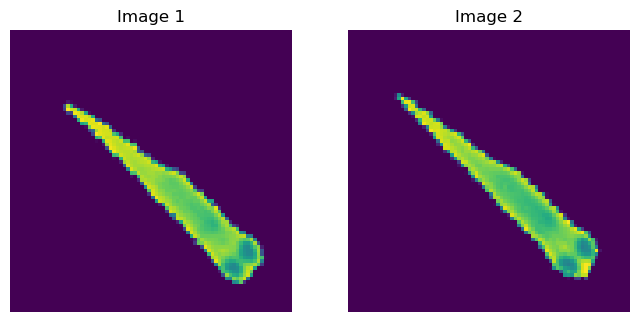

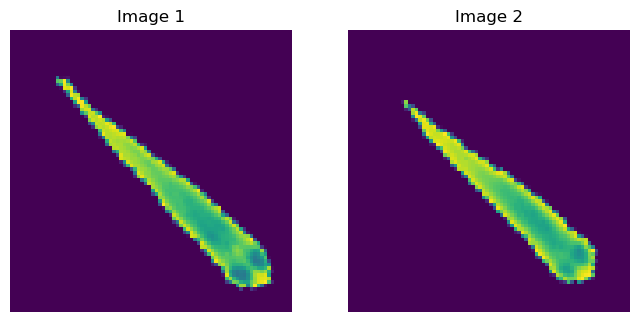

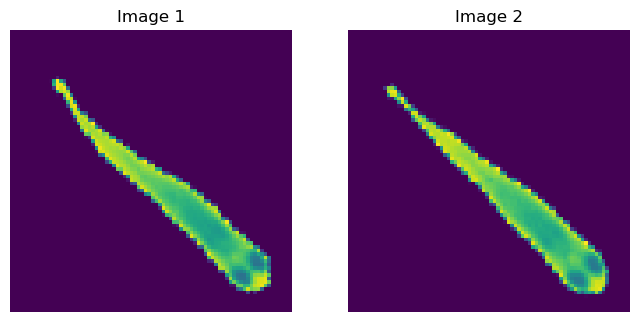

Starting epoch 1/25


  0%|          | 0/157 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [2]:

# Define model parameters
model_params = {
    'image_size': (80, 80),
    'color_channels': 1,
    'embedding_size': 128
}

# Define training parameters
training_params = {
    'num_epochs': 25,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'margin': 2.0,
    'max_batches': 50  # Limit the number of batches for testing
}

# For c++ usage
import numpy as np

def get_data():
    # Generate dummy image data (random noise)
    height, width, channels = 105, 105, 3
    img1_data = np.random.randint(0, 256, (height, width, channels), dtype=np.uint8)
    img2_data = np.random.randint(0, 256, (height, width, channels), dtype=np.uint8)
    label = np.random.choice([0, 1])  # Randomly choose 0 or 1

    return img1_data, img2_data, label

# /// Update callbacks
'''
callbacks['get_data'] = get_data

train_dataset_params = {
    'dataset_class': 'cpp',  # Indicate that we're using the dataset that interfaces with C++
}

# Run the training
trained_model = SiameseTrainer.train_model(
    model_params,
    train_dataset_params,
    training_params,
    callbacks
)
#'''
# ///

#'''
# Build the image dataset
root_dir = 'id_dataset'  # Replace with your dataset path

# Paths to the 'train' and 'val' directories
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

# Build the image datasets
train_image_dataset = build_image_dataset_from_directory(train_dir)
val_image_dataset = build_image_dataset_from_directory(val_dir)

# Check the number of classes and images
print(f"Number of classes in training set: {len(train_image_dataset)}")
print(f"Number of classes in validation set: {len(val_image_dataset)}")

# Define training dataset parameters
train_dataset_params = {
    'dataset_class': 'paths',
    'data': train_image_dataset  # The image dataset built earlier
}

# Define validation dataset parameters
val_dataset_params = {
    'dataset_class': 'paths',
    'data': val_image_dataset  # The image dataset built earlier
}
#'''

# Run the training
trained_model = SiameseTrainer.train_model(
    model_params,
    train_dataset_params,
    val_dataset_params,
    training_params,
    callbacks
)


In [82]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

class SiamesePredictor:
    def __init__(self, model_path, model_params, threshold):
        """
        Initializes the predictor with a trained model.

        Args:
            model_path (str or nn.Module): Path to the saved model file or an instance of the model.
            model_params (dict): Parameters used to initialize the model.
            threshold (float): Threshold for determining similarity.
        """
        # Extract model parameters
        self.image_size = model_params.get('image_size', (105, 105))
        self.color_channels = model_params.get('color_channels', 1)
        self.embedding_size = model_params.get('embedding_size', 128)

        # Device configuration
        self.device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

        # Load the model
        if isinstance(model_path, str):
            self.model = SiameseNetworkPyTorch.load_trained_model(
                filepath=model_path,
                image_size=self.image_size,
                color_channels=self.color_channels,
                embedding_size=self.embedding_size
            )
        elif isinstance(model_path, nn.Module):
            self.model = model_path
        else:
            raise ValueError("Invalid model_path provided.")

        self.model.to(self.device)
        self.model.eval()

        self.threshold = threshold

        # Define transformations based on color channels
        self.transform = self._get_transform()

    def _get_transform(self):
        """
        Defines the transformations to apply to input images.
        Adjusts for grayscale or RGB images based on the model's color_channels.
        """
        if self.color_channels == 1:
            # Grayscale transformations
            transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
        else:
            # RGB transformations
            transform = transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*self.color_channels, std=[0.5]*self.color_channels)
            ])
        return transform

    def predict(self, input1, input2):
        """
        Predicts similarity between inputs. Automatically handles different input types.

        Args:
            input1: Single image, list of images, or set of images.
            input2: Single image, list of images, set of images, or dict of sets.

        Returns:
            See the method's docstring in previous answers for possible returns.
        """
        # Handle single image vs single image
        if self._is_single_image(input1) and self._is_single_image(input2):
            similarity, prediction = self._predict_single_pair(input1, input2)
            return similarity, prediction

        # Handle single image vs list of images
        elif self._is_single_image(input1) and self._is_list_of_images(input2):
            results = self._predict_image_to_images(input1, input2)
            return results

        # Handle list of images vs list of images
        elif self._is_list_of_images(input1) and self._is_list_of_images(input2):
            results = self._predict_images_to_images(input1, input2)
            return results

        # Handle set comparison: input2 is a dict of sets
        elif self._is_list_of_images(input1) and isinstance(input2, dict):
            closest_set, distances = self._compare_set_to_sets(input1, input2)
            return closest_set, distances

        else:
            raise ValueError("Invalid input types for prediction.")

    # Helper methods to determine input types
    def _is_single_image(self, input):
        if isinstance(input, (str, Image.Image)):
            return True
        if isinstance(input, np.ndarray) and (len(input.shape) == 3 or (len(input.shape) == 4 and input.shape[0] == 1)):
            return True
        elif isinstance(input, torch.Tensor) and input.dim() == 4 and input.size(0) == 1:
            return True
        return False

    def _is_list_of_images(self, input):
        if isinstance(input, np.ndarray) and len(input.shape) == 4 and input.shape[0] > 1:
            return True
        return isinstance(input, list) and all(isinstance(i, (str, Image.Image, np.ndarray, torch.Tensor)) for i in input)

    # Prediction methods
    def _predict_single_pair(self, img1, img2):
        # Load and preprocess images
        img1 = self._prepare_input(img1)
        img2 = self._prepare_input(img2)

        # Compute embeddings
        with torch.no_grad():
            output1 = self.model.forward_once(img1)
            output2 = self.model.forward_once(img2)

        # Compute cosine similarity
        cosine_similarity = F.cosine_similarity(output1, output2).item()

        # Make prediction
        prediction = 1.0 if cosine_similarity >= self.threshold else -1.0

        return cosine_similarity, prediction

    def _predict_image_to_images(self, img1, images):
        # Load and preprocess images
        img1 = self._prepare_input(img1)
        img2_batch = self._prepare_batch_input(images)

        # Compute embeddings
        with torch.no_grad():
            output1 = self.model.forward_once(img1)
            output2 = self.model.forward_once(img2_batch)

        # Compute cosine similarities
        cosine_similarities = F.cosine_similarity(output1, output2)

        # Make predictions
        preds = torch.where(cosine_similarities >= self.threshold, torch.tensor(1.0).to(self.device), torch.tensor(-1.0).to(self.device))
        similarities = cosine_similarities.cpu().numpy()
        preds = preds.cpu().numpy()

        # Pair image identifiers with results
        results = list(zip(images, similarities, preds))

        return results

    def _predict_images_to_images(self, images1, images2):
        # Load and preprocess images
        img1_batch = self._prepare_batch_input(images1)
        img2_batch = self._prepare_batch_input(images2)

        # Ensure same batch size
        if len(images1) != len(images2):
            raise ValueError("Both image lists must have the same number of images.")

        # Compute embeddings
        with torch.no_grad():
            output1 = self.model.forward_once(img1_batch)
            output2 = self.model.forward_once(img2_batch)

        # Compute cosine similarities
        cosine_similarities = F.cosine_similarity(output1, output2)

        # Make predictions
        preds = torch.where(cosine_similarities >= self.threshold, torch.tensor(1.0).to(self.device), torch.tensor(-1.0).to(self.device))
        similarities = cosine_similarities.cpu().numpy()
        preds = preds.cpu().numpy()

        # Pair image identifiers with results
        results = list(zip(images1, images2, similarities, preds))

        return results

    def _compare_set_to_sets(self, comp_images, sets_dict):
        """
        Compares a set of images (comp_images) to multiple sets (sets_dict).

        Args:
            comp_images (list): List of images in COMP set.
            sets_dict (dict): Dictionary with set names as keys and list of images as values.

        Returns:
            str: Name of the closest set.
            dict: Average similarities to each set.
        """
        comp_embeddings = self._compute_embeddings(comp_images)

        set_similarities = {}
        for set_name, images in sets_dict.items():
            set_embeddings = self._compute_embeddings(images)
            # Compute similarities between every pair of embeddings
            similarities = self._compute_similarity_matrix(comp_embeddings, set_embeddings)
            # Compute average similarity
            avg_similarity = similarities.mean()
            set_similarities[set_name] = avg_similarity

        # Determine the closest set (highest average similarity)
        closest_set = max(set_similarities, key=set_similarities.get)

        return closest_set, set_similarities

    def _prepare_input(self, img):
        """
        Prepares a single image input, handling different data types efficiently.

        Args:
            img: Image input, can be a path, PIL Image, NumPy array, or tensor.

        Returns:
            Tensor: Preprocessed image tensor ready for model input.
        """
        if isinstance(img, torch.Tensor):
            # Assume tensor is already preprocessed
            img = img.to(self.device)
            if img.dim() == 3:
                img = img.unsqueeze(0)  # Add batch dimension
            return img

        else:
            # Load image if path is provided
            if isinstance(img, str):
                img = Image.open(img)
            elif isinstance(img, np.ndarray):
                # Convert NumPy array to PIL Image
                if img.ndim == 3:
                    if img.shape[2] == 1:
                        # Grayscale image
                        img = Image.fromarray(np.squeeze(img, axis=2).astype('uint8'), mode='L')
                    elif img.shape[2] == 3:
                        # RGB image
                        img = Image.fromarray(img.astype('uint8'), mode='RGB')
                    else:
                        # Handle images with other numbers of channels
                        img = Image.fromarray(img[:, :, :3].astype('uint8'), mode='RGB')
                elif img.ndim == 2:
                    # Grayscale image
                    img = Image.fromarray(img.astype('uint8'), mode='L')
                else:
                    raise ValueError(f"Unsupported NumPy array shape: {img.shape}")
            elif isinstance(img, Image.Image):
                # If it's already a PIL Image, do nothing
                pass
            else:
                raise TypeError(f"Unsupported image type: {type(img)}")

            # Convert image to the appropriate mode
            img = self._convert_image_mode(img)

            # Apply transformations
            img = self.transform(img).unsqueeze(0).to(self.device)
            return img

    def _prepare_batch_input(self, images):
        """
        Prepares a batch of images efficiently.

        Args:
            images: List of image inputs.

        Returns:
            Tensor: Batch of preprocessed images.
        """
        tensors = []
        for img in images:
            tensors.append(self._prepare_input(img))
        # Concatenate tensors along the batch dimension
        batch_tensor = torch.cat(tensors, dim=0)
        return batch_tensor

    def _convert_image_mode(self, img):
        """
        Converts the image to the appropriate mode based on color_channels.

        Args:
            img (PIL.Image): Input image.

        Returns:
            PIL.Image: Image converted to the correct mode.
        """
        if self.color_channels == 1:
            # Convert to grayscale if necessary
            if img.mode != 'L':
                img = img.convert('L')
        else:
            # Convert to RGB if necessary
            if img.mode != 'RGB':
                img = img.convert('RGB')
        return img

    def _compute_embeddings(self, images):
        # Prepare batch input
        img_batch = self._prepare_batch_input(images)

        # Compute embeddings
        with torch.no_grad():
            embeddings = self.model.forward_once(img_batch)

        return embeddings

    def _compute_similarity_matrix(self, embeddings1, embeddings2):
        """
        Computes the pairwise cosine similarity matrix between two sets of embeddings.

        Args:
            embeddings1 (Tensor): Embeddings of the first set (N x D).
            embeddings2 (Tensor): Embeddings of the second set (M x D).

        Returns:
            Tensor: Similarity matrix of size N x M.
        """
        # Normalize embeddings
        embeddings1_norm = F.normalize(embeddings1, p=2, dim=1)
        embeddings2_norm = F.normalize(embeddings2, p=2, dim=1)

        # Compute cosine similarity matrix
        similarities = torch.mm(embeddings1_norm, embeddings2_norm.t())

        # Flatten to a single vector
        similarities = similarities.view(-1).cpu().numpy()

        return similarities

In [83]:
from glob import glob
import os
from sys import dont_write_bytecode

import torch
from torch.utils.data import Dataset
import numpy as np
import random

class SiameseDatasetFromArrays(Dataset):
    def __init__(self, positives, negatives, transform=None):
        """
        Initializes the dataset with positive and negative examples.

        Args:
            positives (list): List of positive examples.
            negatives (list): List of negative examples.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.transform = transform
        self.data = positives + negatives  # Combine positive and negative examples
        random.shuffle(self.data)  # Shuffle the combined data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        label, id1, frame1, image1, id2, frame2, image2 = item

        # Process images
        img1 = self._process_image(image1)
        img2 = self._process_image(image2)

        label = torch.tensor(label, dtype=torch.float32)
        return img1, img2, label

    def _process_image(self, image):
        #print(image.shape, image.dtype, image.min(), image.max())

        # Convert the NumPy array to a tensor
        # Expected shape: (H, W, C) or (H, W)
        '''if image.ndim == 3:
            # Image with channels
            image = np.transpose(image, (2, 0, 1))  # Convert to (C, H, W)
        elif image.ndim == 2:
            # Grayscale image, add channel dimension
            image = image[np.newaxis, :, :]
        else:
            raise ValueError(f"Unsupported image shape: {image.shape}")'''

        # Convert to float and normalize to [0, 1]
        #image = image.astype(np.float32) / 255.0
        #print(image.shape)

        # Convert to tensor
        #img_tensor = torch.from_numpy(image)
        if image.shape[-1] == 3:
            img_tensor = Image.fromarray(image, 'RGB')
        else:
            img_tensor = Image.fromarray(image[..., 0], 'L')

        # Apply transformations if any
        if self.transform:
            img_tensor = self.transform(img_tensor)
        else:
            # Normalize manually if no transform is provided
            raise ValueError("A transform function is required.")
            img_tensor = (img_tensor - 0.5) / 0.5  # Assuming mean=0.5, std=0.5

        return img_tensor

root = '/Users/tristan/trex/docs/notebooks/id_dataset'

def concatenate_npzs(base, verbose=False):
    paths = sorted(glob(base+"_tracklet_images_single_part*.npz"))
    print(paths)

    all_images = []
    all_frames = []
    all_ids = []
    all_frame_segment_indexes = []
    all_frame_segments = []

    number_of_segments = 0

    for path in tqdm(paths):
        with np.load(path) as npz:
            if verbose:
                print(npz.files)
                print(npz['ids'].shape) # (192762,)
                print(npz['images'].shape) # (192762, 80, 80, 1)

            _images = npz['images']
            _frames = npz['frames']
            _ids = npz['ids']
            _frame_segment_indexes = npz['frame_segment_indexes']

            for i in range(_frame_segment_indexes.shape[0]):
                _frame_segment_indexes[i] += number_of_segments
            #_frame_segment_indexes = _frame_segment_indexes + number_of_segments
            _frame_segments = npz['frame_segments']
            number_of_segments += _frame_segments.shape[0]

            all_images.append(_images)
            all_frames.append(_frames)
            all_ids.append(_ids)
            
            all_frame_segment_indexes.append(_frame_segment_indexes)
            all_frame_segments.append(_frame_segments)

            if verbose:
                print(f"loading {path}: {npz['images'].shape} {_frame_segment_indexes.min()} {_frame_segment_indexes.shape}")

    all_images = np.concatenate(all_images, axis=0)
    all_frames = np.concatenate(all_frames, axis=0)
    all_ids = np.concatenate(all_ids, axis=0)
    all_frame_segment_indexes = np.concatenate(all_frame_segment_indexes, axis=0)
    # assert that all segment indexes are unique
    #assert len(np.unique(all_frame_segment_indexes)) == all_frame_segment_indexes.shape[0]
    all_frame_segments = np.concatenate(all_frame_segments, axis=0)

    return all_images, all_frames, all_ids, all_frame_segment_indexes, all_frame_segments

def load_npz_as_dataset(path, dont_use_these_ids = [], verbose=False, split=0.8):
    all_images, all_frames, all_ids, all_frame_segment_indexes, all_frame_segments = concatenate_npzs(path, verbose=verbose)

    # print shapes
    print(all_images.shape, all_frames.shape, all_ids.shape, all_frame_segment_indexes.shape, all_frame_segments.shape)

    all_positives = []
    all_negatives = []

    # save these images (sorted by id) to folders.
    # the root folder is given, then below that we create a folder / id and enumerate
    # the images in that folder.

    # create a folder for each id
    for i, id in enumerate(tqdm(np.unique(all_ids))):
        if id in dont_use_these_ids:
            continue
        folder = os.path.join(root, str(id))
        #os.makedirs(folder, exist_ok=True)

        mask = all_ids == id
        if verbose:
            print(f"id: {all_ids.shape}, images: {all_images[mask].shape}, segments: {all_frame_segments.shape} mask: {mask.shape}")
        _used_indexes = np.unique(all_frame_segment_indexes[mask])

        used_indexes = []
        for s in _used_indexes:
            if s < 0 or s >= all_frame_segments.shape[0]:
                continue
            used_indexes.append(s)
            assert s >= 0 and s < all_frame_segments.shape[0], f"{s} not in {all_frame_segments.shape}"

        if verbose:
            print(f"id: {id}, images: {all_images[mask].shape}, segments: {all_frame_segments[used_indexes]}")

        # get number of images / frame segment
        for s in used_indexes:
            mask = all_frame_segment_indexes == s
            N = mask.sum()

            if verbose:
                print(f"segment: {s}, images: {N} frame_segments: {all_frame_segments.shape}")
            segment = all_frame_segments[s]
            L = segment[-1] - segment[0] + 1

            if verbose:
                print(f"segment: {segment}, images: {N}, L: {L}")

            if N < 100:
                continue

            my_frames = all_frames[mask]
            my_images = all_images[mask]

            # find data of other ids that are in the same frame segment
            current_frame_mask = (all_frames == my_frames[len(my_frames) // 2]) & (all_ids != id) & (np.isin(all_ids, dont_use_these_ids, invert=True))
            _filtered_ids = np.unique(all_ids[current_frame_mask])
            if verbose:
                print(_filtered_ids, "not in", dont_use_these_ids, np.isin(_filtered_ids, dont_use_these_ids).any())
            assert np.isin(id, _filtered_ids).sum() == 0
            assert np.isin(_filtered_ids, dont_use_these_ids).any() == False

            other_indexes = np.unique(all_frame_segment_indexes[current_frame_mask])
            #other_segments = np.array([npz["frame_segments"][idx] for idx in other_indexes])

            # calculate the maximum number of positive examples we can get from within
            # the same segment and the current individual (while maintaining a min_distance
            # between the images):
            min_distance = 10
            n_positives = max(1, int(L / min_distance / 2))

            # sample positives
            _frames = my_frames
            chosen_frames = np.random.choice(_frames, size=n_positives, replace=False)
            chosen_frames = np.sort(chosen_frames)
            # remove the chosen frames from the list of all frames
            _frames = np.setdiff1d(_frames, chosen_frames)

            #print(f"chosen_frames: {chosen_frames} frames: {_frames}")

            # now sample the positives, removing a used paired image from the list of all frames
            positives = []
            for frame in chosen_frames:
                if len(_frames) == 0:
                    print("***> no more frames to choose from")
                    break

                my_image = my_images[my_frames == frame]
                assert len(my_image) == 1
                my_image = my_image[0]

                # now choose the index of the paired image.
                # prefer to choose an image as far away as possible within the same segment
                paired_frame = _frames[np.abs(_frames - frame).argmax()]
                _frames = np.setdiff1d(_frames, [paired_frame])

                paired_image = my_images[my_frames == paired_frame]
                assert len(paired_image) == 1

                assert not id in dont_use_these_ids

                paired_image = paired_image[0]
                positives.append((1.0, id, frame, my_image, id, paired_frame, paired_image))

            if verbose:
                print(f"\tpositives: {len(positives)}")

            # sample images from other segments to get negative examples (dissimilar)
            # we can assume that since the frame segments overlap, both individuals which
            # are visible in the same frame segment are dissimilar. lets sample 10% of the
            # length of the current individuals segment as negative examples.
            n_negatives = max(1, int(1.0 * len(positives)))

            # cache the frames for all other indexes
            other_index_masks = {}
            for idx in other_indexes:
                other_frame_mask = (all_frame_segment_indexes == idx)
                ids = np.unique(all_ids[other_frame_mask])
                assert len(ids) == 1, f"more than one id in frame segment when searching for idx {idx}: {ids}"
                assert not ids[0] in dont_use_these_ids
                other_index_masks[idx] = (other_frame_mask, ids[0], all_frames[other_frame_mask], all_images[other_frame_mask])

            # sample negatives
            #print(f"other_indexes: {len(other_indexes)}")
            if len(other_indexes) == 0:
                continue
            
            chosen_negatives = np.random.randint(0, len(other_indexes), size=n_negatives)
            chosen_indexes = other_indexes[chosen_negatives]

            negatives = []

            for other_index in chosen_indexes:
                # sample a random index from that segment
                other_frame_mask, other_id, _frames, _images = other_index_masks[other_index]

                found = False
                for _ in range(5):
                    index = np.random.randint(0, len(_images))
                    frame = _frames[index]

                    my_image = my_images[my_frames == frame]
                    if len(my_image) == 0:
                        if verbose:
                            print(f"\t XX frame: {frame} no image found")
                        continue
                    else:
                        my_image = my_image[0]
                        
                        if verbose:
                            print(f"\t => frame: {frame}, image: {len(my_image)} my_images: {my_images.shape}, other_images: {_images.shape}")
                            print(frame, "in", my_frames)

                            print(f"\t\t my_image: {my_image.shape} other_images: {_images[index].shape}")

                        assert not id in dont_use_these_ids
                        assert not other_id in dont_use_these_ids
                        
                        other_image = (-1.0, id, frame, my_image, other_id, frame, _images[index])
                        negatives.append(other_image)
                        found = True
                        break
                
                if not found and verbose:
                    print(f"\t ** frame: {frame} no image found at all")

            if verbose:
                print(f"\tnegatives: {len(negatives)}")

            all_positives.extend(positives)
            all_negatives.extend(negatives)

            
        #break

    for label, id1, frame1, image1, id2, frame2, image2 in all_positives:
        assert np.isin([id1, id2], list(dont_use_these_ids)).sum() == 0
    
    for label, id1, frame1, image1, id2, frame2, image2 in all_negatives:
        assert np.isin([id1, id2], list(dont_use_these_ids)).sum() == 0

    # Define model parameters
    image_size = all_images.shape[1:-1]
    print(image_size)

    color_channels = all_images.shape[-1]
    print(f"Color channels: {color_channels}")

    # split the data into training and validation sets
    split_ratio = split
    split_index = int(split_ratio * len(all_positives))

    np.random.seed(0)
    np.random.shuffle(all_positives)
    np.random.shuffle(all_negatives)

    train_positives = all_positives[:split_index]
    val_positives = all_positives[split_index:]

    train_negatives = all_negatives[:split_index]
    val_negatives = all_negatives[split_index:]

    # Define the model parameters
    model_params = {
        'image_size': image_size,
        'color_channels': color_channels,
        'embedding_size': 128
    }

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomAffine(degrees=0.05, translate=(0.05, 0.1), scale=None), #(0.99, 1.01)),
        #transforms.RandomAutocontrast(),
        #transforms.RandAugment(2, 9),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * model_params["color_channels"], std=[0.5] * model_params["color_channels"])
    ])

    val_dataset = SiameseDatasetFromArrays(
        val_positives,
        val_negatives,
        transform=transform
    )

    train_dataset = SiameseDatasetFromArrays(
        train_positives,
        train_negatives,
        transform=transform
    )

    return val_dataset, train_dataset, model_params

#val_dataset, train_dataset = load_npz_as_dataset('/Users/tristan/Videos/data/group_1_tracklet_images_single_part0.npz', dont_use_these_ids=[5,3,1])
val_dataset, train_dataset, model_params = load_npz_as_dataset('/Users/tristan/Downloads/For Tristan/data/ForTristan', dont_use_these_ids=[])

['/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part0.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part1.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part2.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part3.npz']


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


(288614, 80, 80, 3) (288614,) (288614,) (288614,) (12253, 2)


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


(80, 80)
Color channels: 3


In [85]:
# Define the training parameters
training_params = {
    'num_epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.001,
    'patience': 15,
    #'margin': 2.0,
    'threshold': 0.5
}

# Check the number of classes and images
print(f"Number of classes in training set: {len(train_dataset)}")
print(f"Number of classes in validation set: {len(val_dataset)}")

# Define training dataset parameters
train_dataset_params = {
    'dataset_class': 'dataset',
    'data': train_dataset  # The image dataset built earlier
}

# Define validation dataset parameters
val_dataset_params = {
    'dataset_class': 'dataset',
    'data': val_dataset  # The image dataset built earlier
}
#'''


# Run the training
trained_model = SiameseTrainer.train_model(
    model_params,
    train_dataset_params,
    val_dataset_params,
    training_params,
    callbacks
)


Number of classes in training set: 4764
Number of classes in validation set: 1018
Training on mps, with 3 color channels
Starting epoch 1/100


100%|██████████| 75/75 [00:07<00:00, 10.24it/s]


Epoch [1/100] completed. Average Training Loss: 0.4820, Training Accuracy: 0.5248


100%|██████████| 16/16 [00:00<00:00, 23.26it/s]


Epoch [1/100] Validation Loss: 0.4135, Validation Accuracy: 0.5855
Validation loss decreased (0.4135). Saving model ...
[Callback] Model saved at epoch 1
[Callback] Epoch 1 ended.
Training Loss: 0.4820, Training Accuracy: 0.5248
Validation Loss: 0.4135, Validation Accuracy: 0.5855
Starting epoch 2/100


100%|██████████| 75/75 [00:07<00:00, 10.18it/s]


Epoch [2/100] completed. Average Training Loss: 0.4989, Training Accuracy: 0.5000


100%|██████████| 16/16 [00:00<00:00, 23.39it/s]


Epoch [2/100] Validation Loss: 0.4155, Validation Accuracy: 0.5855
Epochs without improvement: 1/15
[Callback] Epoch 2 ended.
Training Loss: 0.4989, Training Accuracy: 0.5000
Validation Loss: 0.4155, Validation Accuracy: 0.5855
Starting epoch 3/100


100%|██████████| 75/75 [00:07<00:00, 10.17it/s]


Epoch [3/100] completed. Average Training Loss: 0.4775, Training Accuracy: 0.5258


100%|██████████| 16/16 [00:00<00:00, 23.60it/s]


Epoch [3/100] Validation Loss: 0.4053, Validation Accuracy: 0.5923
Validation loss decreased (0.4053). Saving model ...
[Callback] Model saved at epoch 3
[Callback] Epoch 3 ended.
Training Loss: 0.4775, Training Accuracy: 0.5258
Validation Loss: 0.4053, Validation Accuracy: 0.5923
Starting epoch 4/100


100%|██████████| 75/75 [00:07<00:00, 10.14it/s]


Epoch [4/100] completed. Average Training Loss: 0.4741, Training Accuracy: 0.5321


100%|██████████| 16/16 [00:00<00:00, 22.39it/s]


Epoch [4/100] Validation Loss: 0.4106, Validation Accuracy: 0.5884
Epochs without improvement: 1/15
[Callback] Epoch 4 ended.
Training Loss: 0.4741, Training Accuracy: 0.5321
Validation Loss: 0.4106, Validation Accuracy: 0.5884
Starting epoch 5/100


100%|██████████| 75/75 [00:07<00:00, 10.07it/s]


Epoch [5/100] completed. Average Training Loss: 0.4609, Training Accuracy: 0.5426


100%|██████████| 16/16 [00:00<00:00, 22.96it/s]


Epoch [5/100] Validation Loss: 0.3916, Validation Accuracy: 0.6169
Validation loss decreased (0.3916). Saving model ...
[Callback] Model saved at epoch 5
[Callback] Epoch 5 ended.
Training Loss: 0.4609, Training Accuracy: 0.5426
Validation Loss: 0.3916, Validation Accuracy: 0.6169
Starting epoch 6/100


100%|██████████| 75/75 [00:07<00:00, 10.12it/s]


Epoch [6/100] completed. Average Training Loss: 0.4234, Training Accuracy: 0.5854


100%|██████████| 16/16 [00:00<00:00, 21.59it/s]


Epoch [6/100] Validation Loss: 0.4225, Validation Accuracy: 0.6012
Epochs without improvement: 1/15
[Callback] Epoch 6 ended.
Training Loss: 0.4234, Training Accuracy: 0.5854
Validation Loss: 0.4225, Validation Accuracy: 0.6012
Starting epoch 7/100


100%|██████████| 75/75 [00:07<00:00, 10.15it/s]


Epoch [7/100] completed. Average Training Loss: 0.4013, Training Accuracy: 0.6085


100%|██████████| 16/16 [00:00<00:00, 23.40it/s]


Epoch [7/100] Validation Loss: 0.4007, Validation Accuracy: 0.6208
Epochs without improvement: 2/15
[Callback] Epoch 7 ended.
Training Loss: 0.4013, Training Accuracy: 0.6085
Validation Loss: 0.4007, Validation Accuracy: 0.6208
Starting epoch 8/100


100%|██████████| 75/75 [00:07<00:00, 10.11it/s]


Epoch [8/100] completed. Average Training Loss: 0.3840, Training Accuracy: 0.6291


100%|██████████| 16/16 [00:00<00:00, 22.39it/s]


Epoch [8/100] Validation Loss: 0.3842, Validation Accuracy: 0.6238
Validation loss decreased (0.3842). Saving model ...
[Callback] Model saved at epoch 8
[Callback] Epoch 8 ended.
Training Loss: 0.3840, Training Accuracy: 0.6291
Validation Loss: 0.3842, Validation Accuracy: 0.6238
Starting epoch 9/100


100%|██████████| 75/75 [00:07<00:00, 10.11it/s]


Epoch [9/100] completed. Average Training Loss: 0.3735, Training Accuracy: 0.6404


100%|██████████| 16/16 [00:00<00:00, 22.86it/s]


Epoch [9/100] Validation Loss: 0.3583, Validation Accuracy: 0.6611
Validation loss decreased (0.3583). Saving model ...
[Callback] Model saved at epoch 9
[Callback] Epoch 9 ended.
Training Loss: 0.3735, Training Accuracy: 0.6404
Validation Loss: 0.3583, Validation Accuracy: 0.6611
Starting epoch 10/100


100%|██████████| 75/75 [00:07<00:00, 10.15it/s]


Epoch [10/100] completed. Average Training Loss: 0.3648, Training Accuracy: 0.6513


100%|██████████| 16/16 [00:00<00:00, 22.85it/s]


Epoch [10/100] Validation Loss: 0.3460, Validation Accuracy: 0.6807
Validation loss decreased (0.3460). Saving model ...
[Callback] Model saved at epoch 10
[Callback] Epoch 10 ended.
Training Loss: 0.3648, Training Accuracy: 0.6513
Validation Loss: 0.3460, Validation Accuracy: 0.6807
Starting epoch 11/100


100%|██████████| 75/75 [00:07<00:00, 10.08it/s]


Epoch [11/100] completed. Average Training Loss: 0.3694, Training Accuracy: 0.6442


100%|██████████| 16/16 [00:00<00:00, 22.21it/s]


Epoch [11/100] Validation Loss: 0.3556, Validation Accuracy: 0.6572
Epochs without improvement: 1/15
[Callback] Epoch 11 ended.
Training Loss: 0.3694, Training Accuracy: 0.6442
Validation Loss: 0.3556, Validation Accuracy: 0.6572
Starting epoch 12/100


100%|██████████| 75/75 [00:07<00:00,  9.66it/s]


Epoch [12/100] completed. Average Training Loss: 0.3500, Training Accuracy: 0.6669


100%|██████████| 16/16 [00:00<00:00, 21.18it/s]


Epoch [12/100] Validation Loss: 0.3366, Validation Accuracy: 0.6847
Validation loss decreased (0.3366). Saving model ...
[Callback] Model saved at epoch 12
[Callback] Epoch 12 ended.
Training Loss: 0.3500, Training Accuracy: 0.6669
Validation Loss: 0.3366, Validation Accuracy: 0.6847
Starting epoch 13/100


100%|██████████| 75/75 [00:07<00:00, 10.07it/s]


Epoch [13/100] completed. Average Training Loss: 0.3489, Training Accuracy: 0.6700


100%|██████████| 16/16 [00:00<00:00, 22.87it/s]


Epoch [13/100] Validation Loss: 0.3117, Validation Accuracy: 0.7161
Validation loss decreased (0.3117). Saving model ...
[Callback] Model saved at epoch 13
[Callback] Epoch 13 ended.
Training Loss: 0.3489, Training Accuracy: 0.6700
Validation Loss: 0.3117, Validation Accuracy: 0.7161
Starting epoch 14/100


100%|██████████| 75/75 [00:07<00:00, 10.17it/s]


Epoch [14/100] completed. Average Training Loss: 0.3352, Training Accuracy: 0.6816


100%|██████████| 16/16 [00:00<00:00, 23.06it/s]


Epoch [14/100] Validation Loss: 0.2937, Validation Accuracy: 0.7358
Validation loss decreased (0.2937). Saving model ...
[Callback] Model saved at epoch 14
[Callback] Epoch 14 ended.
Training Loss: 0.3352, Training Accuracy: 0.6816
Validation Loss: 0.2937, Validation Accuracy: 0.7358
Starting epoch 15/100


100%|██████████| 75/75 [00:07<00:00, 10.26it/s]


Epoch [15/100] completed. Average Training Loss: 0.3347, Training Accuracy: 0.6835


100%|██████████| 16/16 [00:00<00:00, 20.82it/s]


Epoch [15/100] Validation Loss: 0.3422, Validation Accuracy: 0.6768
Epochs without improvement: 1/15
[Callback] Epoch 15 ended.
Training Loss: 0.3347, Training Accuracy: 0.6835
Validation Loss: 0.3422, Validation Accuracy: 0.6768
Starting epoch 16/100


100%|██████████| 75/75 [00:07<00:00,  9.80it/s]


Epoch [16/100] completed. Average Training Loss: 0.3292, Training Accuracy: 0.6908


100%|██████████| 16/16 [00:00<00:00, 22.76it/s]


Epoch [16/100] Validation Loss: 0.3138, Validation Accuracy: 0.7151
Epochs without improvement: 2/15
[Callback] Epoch 16 ended.
Training Loss: 0.3292, Training Accuracy: 0.6908
Validation Loss: 0.3138, Validation Accuracy: 0.7151
Starting epoch 17/100


100%|██████████| 75/75 [00:07<00:00,  9.84it/s]


Epoch [17/100] completed. Average Training Loss: 0.3233, Training Accuracy: 0.6979


100%|██████████| 16/16 [00:00<00:00, 22.79it/s]


Epoch [17/100] Validation Loss: 0.3192, Validation Accuracy: 0.6965
Epochs without improvement: 3/15
[Callback] Epoch 17 ended.
Training Loss: 0.3233, Training Accuracy: 0.6979
Validation Loss: 0.3192, Validation Accuracy: 0.6965
Starting epoch 18/100


100%|██████████| 75/75 [00:07<00:00, 10.13it/s]


Epoch [18/100] completed. Average Training Loss: 0.2998, Training Accuracy: 0.7244


100%|██████████| 16/16 [00:00<00:00, 22.46it/s]


Epoch [18/100] Validation Loss: 0.2741, Validation Accuracy: 0.7583
Validation loss decreased (0.2741). Saving model ...
[Callback] Model saved at epoch 18
[Callback] Epoch 18 ended.
Training Loss: 0.2998, Training Accuracy: 0.7244
Validation Loss: 0.2741, Validation Accuracy: 0.7583
Starting epoch 19/100


100%|██████████| 75/75 [00:07<00:00, 10.12it/s]


Epoch [19/100] completed. Average Training Loss: 0.2932, Training Accuracy: 0.7328


100%|██████████| 16/16 [00:00<00:00, 23.10it/s]


Epoch [19/100] Validation Loss: 0.2744, Validation Accuracy: 0.7623
Epochs without improvement: 1/15
[Callback] Epoch 19 ended.
Training Loss: 0.2932, Training Accuracy: 0.7328
Validation Loss: 0.2744, Validation Accuracy: 0.7623
Starting epoch 20/100


100%|██████████| 75/75 [00:07<00:00, 10.13it/s]


Epoch [20/100] completed. Average Training Loss: 0.2869, Training Accuracy: 0.7401


100%|██████████| 16/16 [00:00<00:00, 22.66it/s]


Epoch [20/100] Validation Loss: 0.2700, Validation Accuracy: 0.7652
Validation loss decreased (0.2700). Saving model ...
[Callback] Model saved at epoch 20
[Callback] Epoch 20 ended.
Training Loss: 0.2869, Training Accuracy: 0.7401
Validation Loss: 0.2700, Validation Accuracy: 0.7652
Starting epoch 21/100


100%|██████████| 75/75 [00:07<00:00, 10.09it/s]


Epoch [21/100] completed. Average Training Loss: 0.2831, Training Accuracy: 0.7422


100%|██████████| 16/16 [00:00<00:00, 21.59it/s]


Epoch [21/100] Validation Loss: 0.2672, Validation Accuracy: 0.7711
Validation loss decreased (0.2672). Saving model ...
[Callback] Model saved at epoch 21
[Callback] Epoch 21 ended.
Training Loss: 0.2831, Training Accuracy: 0.7422
Validation Loss: 0.2672, Validation Accuracy: 0.7711
Starting epoch 22/100


100%|██████████| 75/75 [00:07<00:00,  9.68it/s]


Epoch [22/100] completed. Average Training Loss: 0.2822, Training Accuracy: 0.7427


100%|██████████| 16/16 [00:00<00:00, 21.44it/s]


Epoch [22/100] Validation Loss: 0.2774, Validation Accuracy: 0.7711
Epochs without improvement: 1/15
[Callback] Epoch 22 ended.
Training Loss: 0.2822, Training Accuracy: 0.7427
Validation Loss: 0.2774, Validation Accuracy: 0.7711
Starting epoch 23/100


100%|██████████| 75/75 [00:07<00:00,  9.76it/s]


Epoch [23/100] completed. Average Training Loss: 0.2783, Training Accuracy: 0.7473


100%|██████████| 16/16 [00:00<00:00, 20.82it/s]


Epoch [23/100] Validation Loss: 0.2618, Validation Accuracy: 0.7652
Validation loss decreased (0.2618). Saving model ...
[Callback] Model saved at epoch 23
[Callback] Epoch 23 ended.
Training Loss: 0.2783, Training Accuracy: 0.7473
Validation Loss: 0.2618, Validation Accuracy: 0.7652
Starting epoch 24/100


100%|██████████| 75/75 [00:07<00:00,  9.73it/s]


Epoch [24/100] completed. Average Training Loss: 0.2791, Training Accuracy: 0.7485


100%|██████████| 16/16 [00:00<00:00, 22.25it/s]


Epoch [24/100] Validation Loss: 0.2642, Validation Accuracy: 0.7642
Epochs without improvement: 1/15
[Callback] Epoch 24 ended.
Training Loss: 0.2791, Training Accuracy: 0.7485
Validation Loss: 0.2642, Validation Accuracy: 0.7642
Starting epoch 25/100


100%|██████████| 75/75 [00:07<00:00,  9.77it/s]


Epoch [25/100] completed. Average Training Loss: 0.2719, Training Accuracy: 0.7582


100%|██████████| 16/16 [00:00<00:00, 22.12it/s]


Epoch [25/100] Validation Loss: 0.2536, Validation Accuracy: 0.7898
Validation loss decreased (0.2536). Saving model ...
[Callback] Model saved at epoch 25
[Callback] Epoch 25 ended.
Training Loss: 0.2719, Training Accuracy: 0.7582
Validation Loss: 0.2536, Validation Accuracy: 0.7898
Starting epoch 26/100


100%|██████████| 75/75 [00:07<00:00,  9.69it/s]


Epoch [26/100] completed. Average Training Loss: 0.2686, Training Accuracy: 0.7565


100%|██████████| 16/16 [00:00<00:00, 21.35it/s]


Epoch [26/100] Validation Loss: 0.2550, Validation Accuracy: 0.7760
Epochs without improvement: 1/15
[Callback] Epoch 26 ended.
Training Loss: 0.2686, Training Accuracy: 0.7565
Validation Loss: 0.2550, Validation Accuracy: 0.7760
Starting epoch 27/100


100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


Epoch [27/100] completed. Average Training Loss: 0.2722, Training Accuracy: 0.7523


100%|██████████| 16/16 [00:00<00:00, 22.28it/s]


Epoch [27/100] Validation Loss: 0.2578, Validation Accuracy: 0.7859
Epochs without improvement: 2/15
[Callback] Epoch 27 ended.
Training Loss: 0.2722, Training Accuracy: 0.7523
Validation Loss: 0.2578, Validation Accuracy: 0.7859
Starting epoch 28/100


100%|██████████| 75/75 [00:07<00:00,  9.74it/s]


Epoch [28/100] completed. Average Training Loss: 0.2678, Training Accuracy: 0.7580


100%|██████████| 16/16 [00:00<00:00, 22.60it/s]


Epoch [28/100] Validation Loss: 0.2729, Validation Accuracy: 0.7711
Epochs without improvement: 3/15
[Callback] Epoch 28 ended.
Training Loss: 0.2678, Training Accuracy: 0.7580
Validation Loss: 0.2729, Validation Accuracy: 0.7711
Starting epoch 29/100


100%|██████████| 75/75 [00:07<00:00,  9.72it/s]


Epoch [29/100] completed. Average Training Loss: 0.2620, Training Accuracy: 0.7687


100%|██████████| 16/16 [00:00<00:00, 20.83it/s]


Epoch [29/100] Validation Loss: 0.2490, Validation Accuracy: 0.7888
Validation loss decreased (0.2490). Saving model ...
[Callback] Model saved at epoch 29
[Callback] Epoch 29 ended.
Training Loss: 0.2620, Training Accuracy: 0.7687
Validation Loss: 0.2490, Validation Accuracy: 0.7888
Starting epoch 30/100


100%|██████████| 75/75 [00:07<00:00,  9.72it/s]


Epoch [30/100] completed. Average Training Loss: 0.2541, Training Accuracy: 0.7769


100%|██████████| 16/16 [00:00<00:00, 22.47it/s]


Epoch [30/100] Validation Loss: 0.2455, Validation Accuracy: 0.7878
Validation loss decreased (0.2455). Saving model ...
[Callback] Model saved at epoch 30
[Callback] Epoch 30 ended.
Training Loss: 0.2541, Training Accuracy: 0.7769
Validation Loss: 0.2455, Validation Accuracy: 0.7878
Starting epoch 31/100


100%|██████████| 75/75 [00:07<00:00,  9.76it/s]


Epoch [31/100] completed. Average Training Loss: 0.2591, Training Accuracy: 0.7651


100%|██████████| 16/16 [00:00<00:00, 22.25it/s]


Epoch [31/100] Validation Loss: 0.2516, Validation Accuracy: 0.7878
Epochs without improvement: 1/15
[Callback] Epoch 31 ended.
Training Loss: 0.2591, Training Accuracy: 0.7651
Validation Loss: 0.2516, Validation Accuracy: 0.7878
Starting epoch 32/100


100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


Epoch [32/100] completed. Average Training Loss: 0.2565, Training Accuracy: 0.7731


100%|██████████| 16/16 [00:00<00:00, 20.53it/s]


Epoch [32/100] Validation Loss: 0.2482, Validation Accuracy: 0.7917
Epochs without improvement: 2/15
[Callback] Epoch 32 ended.
Training Loss: 0.2565, Training Accuracy: 0.7731
Validation Loss: 0.2482, Validation Accuracy: 0.7917
Starting epoch 33/100


100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


Epoch [33/100] completed. Average Training Loss: 0.2604, Training Accuracy: 0.7655


100%|██████████| 16/16 [00:00<00:00, 22.69it/s]


Epoch [33/100] Validation Loss: 0.2453, Validation Accuracy: 0.7898
Validation loss decreased (0.2453). Saving model ...
[Callback] Model saved at epoch 33
[Callback] Epoch 33 ended.
Training Loss: 0.2604, Training Accuracy: 0.7655
Validation Loss: 0.2453, Validation Accuracy: 0.7898
Starting epoch 34/100


100%|██████████| 75/75 [00:07<00:00,  9.69it/s]


Epoch [34/100] completed. Average Training Loss: 0.2577, Training Accuracy: 0.7645


100%|██████████| 16/16 [00:00<00:00, 22.52it/s]


Epoch [34/100] Validation Loss: 0.2532, Validation Accuracy: 0.7780
Epochs without improvement: 1/15
[Callback] Epoch 34 ended.
Training Loss: 0.2577, Training Accuracy: 0.7645
Validation Loss: 0.2532, Validation Accuracy: 0.7780
Starting epoch 35/100


100%|██████████| 75/75 [00:07<00:00,  9.74it/s]


Epoch [35/100] completed. Average Training Loss: 0.2593, Training Accuracy: 0.7716


100%|██████████| 16/16 [00:00<00:00, 22.00it/s]


Epoch [35/100] Validation Loss: 0.2480, Validation Accuracy: 0.7859
Epochs without improvement: 2/15
[Callback] Epoch 35 ended.
Training Loss: 0.2593, Training Accuracy: 0.7716
Validation Loss: 0.2480, Validation Accuracy: 0.7859
Starting epoch 36/100


100%|██████████| 75/75 [00:07<00:00,  9.79it/s]


Epoch [36/100] completed. Average Training Loss: 0.2542, Training Accuracy: 0.7704


100%|██████████| 16/16 [00:00<00:00, 20.62it/s]


Epoch [36/100] Validation Loss: 0.2480, Validation Accuracy: 0.7898
Epochs without improvement: 3/15
[Callback] Epoch 36 ended.
Training Loss: 0.2542, Training Accuracy: 0.7704
Validation Loss: 0.2480, Validation Accuracy: 0.7898
Starting epoch 37/100


100%|██████████| 75/75 [00:07<00:00,  9.72it/s]


Epoch [37/100] completed. Average Training Loss: 0.2598, Training Accuracy: 0.7670


100%|██████████| 16/16 [00:00<00:00, 22.64it/s]


Epoch [37/100] Validation Loss: 0.2489, Validation Accuracy: 0.7888
Epochs without improvement: 4/15
[Callback] Epoch 37 ended.
Training Loss: 0.2598, Training Accuracy: 0.7670
Validation Loss: 0.2489, Validation Accuracy: 0.7888
Starting epoch 38/100


100%|██████████| 75/75 [00:07<00:00,  9.76it/s]


Epoch [38/100] completed. Average Training Loss: 0.2590, Training Accuracy: 0.7674


100%|██████████| 16/16 [00:00<00:00, 22.89it/s]


Epoch [38/100] Validation Loss: 0.2433, Validation Accuracy: 0.7976
Validation loss decreased (0.2433). Saving model ...
[Callback] Model saved at epoch 38
[Callback] Epoch 38 ended.
Training Loss: 0.2590, Training Accuracy: 0.7674
Validation Loss: 0.2433, Validation Accuracy: 0.7976
Starting epoch 39/100


100%|██████████| 75/75 [00:07<00:00,  9.74it/s]


Epoch [39/100] completed. Average Training Loss: 0.2562, Training Accuracy: 0.7699


100%|██████████| 16/16 [00:00<00:00, 21.45it/s]


Epoch [39/100] Validation Loss: 0.2492, Validation Accuracy: 0.7849
Epochs without improvement: 1/15
[Callback] Epoch 39 ended.
Training Loss: 0.2562, Training Accuracy: 0.7699
Validation Loss: 0.2492, Validation Accuracy: 0.7849
Starting epoch 40/100


100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


Epoch [40/100] completed. Average Training Loss: 0.2538, Training Accuracy: 0.7714


100%|██████████| 16/16 [00:00<00:00, 22.23it/s]


Epoch [40/100] Validation Loss: 0.2457, Validation Accuracy: 0.7859
Epochs without improvement: 2/15
[Callback] Epoch 40 ended.
Training Loss: 0.2538, Training Accuracy: 0.7714
Validation Loss: 0.2457, Validation Accuracy: 0.7859
Starting epoch 41/100


100%|██████████| 75/75 [00:07<00:00,  9.77it/s]


Epoch [41/100] completed. Average Training Loss: 0.2540, Training Accuracy: 0.7754


100%|██████████| 16/16 [00:00<00:00, 22.85it/s]


Epoch [41/100] Validation Loss: 0.2445, Validation Accuracy: 0.7800
Epochs without improvement: 3/15
[Callback] Epoch 41 ended.
Training Loss: 0.2540, Training Accuracy: 0.7754
Validation Loss: 0.2445, Validation Accuracy: 0.7800
Starting epoch 42/100


100%|██████████| 75/75 [00:07<00:00,  9.73it/s]


Epoch [42/100] completed. Average Training Loss: 0.2568, Training Accuracy: 0.7727


100%|██████████| 16/16 [00:00<00:00, 21.81it/s]


Epoch [42/100] Validation Loss: 0.2464, Validation Accuracy: 0.7947
Epochs without improvement: 4/15
[Callback] Epoch 42 ended.
Training Loss: 0.2568, Training Accuracy: 0.7727
Validation Loss: 0.2464, Validation Accuracy: 0.7947
Starting epoch 43/100


100%|██████████| 75/75 [00:07<00:00,  9.74it/s]


Epoch [43/100] completed. Average Training Loss: 0.2589, Training Accuracy: 0.7689


100%|██████████| 16/16 [00:00<00:00, 22.06it/s]


Epoch [43/100] Validation Loss: 0.2401, Validation Accuracy: 0.7986
Validation loss decreased (0.2401). Saving model ...
[Callback] Model saved at epoch 43
[Callback] Epoch 43 ended.
Training Loss: 0.2589, Training Accuracy: 0.7689
Validation Loss: 0.2401, Validation Accuracy: 0.7986
Starting epoch 44/100


100%|██████████| 75/75 [00:07<00:00,  9.77it/s]


Epoch [44/100] completed. Average Training Loss: 0.2520, Training Accuracy: 0.7704


100%|██████████| 16/16 [00:00<00:00, 22.32it/s]


Epoch [44/100] Validation Loss: 0.2471, Validation Accuracy: 0.7809
Epochs without improvement: 1/15
[Callback] Epoch 44 ended.
Training Loss: 0.2520, Training Accuracy: 0.7704
Validation Loss: 0.2471, Validation Accuracy: 0.7809
Starting epoch 45/100


100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


Epoch [45/100] completed. Average Training Loss: 0.2534, Training Accuracy: 0.7743


100%|██████████| 16/16 [00:00<00:00, 21.68it/s]


Epoch [45/100] Validation Loss: 0.2516, Validation Accuracy: 0.7859
Epochs without improvement: 2/15
[Callback] Epoch 45 ended.
Training Loss: 0.2534, Training Accuracy: 0.7743
Validation Loss: 0.2516, Validation Accuracy: 0.7859
Starting epoch 46/100


100%|██████████| 75/75 [00:07<00:00,  9.76it/s]


Epoch [46/100] completed. Average Training Loss: 0.2583, Training Accuracy: 0.7674


100%|██████████| 16/16 [00:00<00:00, 22.39it/s]


Epoch [46/100] Validation Loss: 0.2531, Validation Accuracy: 0.7819
Epochs without improvement: 3/15
[Callback] Epoch 46 ended.
Training Loss: 0.2583, Training Accuracy: 0.7674
Validation Loss: 0.2531, Validation Accuracy: 0.7819
Starting epoch 47/100


100%|██████████| 75/75 [00:07<00:00,  9.75it/s]


Epoch [47/100] completed. Average Training Loss: 0.2520, Training Accuracy: 0.7720


100%|██████████| 16/16 [00:00<00:00, 22.26it/s]


Epoch [47/100] Validation Loss: 0.2467, Validation Accuracy: 0.8006
Epochs without improvement: 4/15
[Callback] Epoch 47 ended.
Training Loss: 0.2520, Training Accuracy: 0.7720
Validation Loss: 0.2467, Validation Accuracy: 0.8006
Starting epoch 48/100


100%|██████████| 75/75 [00:07<00:00,  9.73it/s]


Epoch [48/100] completed. Average Training Loss: 0.2550, Training Accuracy: 0.7699


100%|██████████| 16/16 [00:00<00:00, 21.39it/s]


Epoch [48/100] Validation Loss: 0.2472, Validation Accuracy: 0.7917
Epochs without improvement: 5/15
[Callback] Epoch 48 ended.
Training Loss: 0.2550, Training Accuracy: 0.7699
Validation Loss: 0.2472, Validation Accuracy: 0.7917
Starting epoch 49/100


100%|██████████| 75/75 [00:07<00:00,  9.79it/s]


Epoch [49/100] completed. Average Training Loss: 0.2552, Training Accuracy: 0.7725


100%|██████████| 16/16 [00:00<00:00, 21.79it/s]


Epoch [49/100] Validation Loss: 0.2466, Validation Accuracy: 0.7898
Epochs without improvement: 6/15
[Callback] Epoch 49 ended.
Training Loss: 0.2552, Training Accuracy: 0.7725
Validation Loss: 0.2466, Validation Accuracy: 0.7898
Starting epoch 50/100


100%|██████████| 75/75 [00:07<00:00,  9.75it/s]


Epoch [50/100] completed. Average Training Loss: 0.2526, Training Accuracy: 0.7800


100%|██████████| 16/16 [00:00<00:00, 22.68it/s]


Epoch [50/100] Validation Loss: 0.2549, Validation Accuracy: 0.7731
Epochs without improvement: 7/15
[Callback] Epoch 50 ended.
Training Loss: 0.2526, Training Accuracy: 0.7800
Validation Loss: 0.2549, Validation Accuracy: 0.7731
Starting epoch 51/100


100%|██████████| 75/75 [00:07<00:00,  9.72it/s]


Epoch [51/100] completed. Average Training Loss: 0.2565, Training Accuracy: 0.7683


100%|██████████| 16/16 [00:00<00:00, 21.93it/s]


Epoch [51/100] Validation Loss: 0.2455, Validation Accuracy: 0.7937
Epochs without improvement: 8/15
[Callback] Epoch 51 ended.
Training Loss: 0.2565, Training Accuracy: 0.7683
Validation Loss: 0.2455, Validation Accuracy: 0.7937
Starting epoch 52/100


100%|██████████| 75/75 [00:07<00:00,  9.71it/s]


Epoch [52/100] completed. Average Training Loss: 0.2550, Training Accuracy: 0.7718


100%|██████████| 16/16 [00:00<00:00, 21.93it/s]


Epoch [52/100] Validation Loss: 0.2462, Validation Accuracy: 0.7898
Epochs without improvement: 9/15
[Callback] Epoch 52 ended.
Training Loss: 0.2550, Training Accuracy: 0.7718
Validation Loss: 0.2462, Validation Accuracy: 0.7898
Starting epoch 53/100


100%|██████████| 75/75 [00:07<00:00,  9.75it/s]


Epoch [53/100] completed. Average Training Loss: 0.2566, Training Accuracy: 0.7714


100%|██████████| 16/16 [00:00<00:00, 22.38it/s]


Epoch [53/100] Validation Loss: 0.2449, Validation Accuracy: 0.7917
Epochs without improvement: 10/15
[Callback] Epoch 53 ended.
Training Loss: 0.2566, Training Accuracy: 0.7714
Validation Loss: 0.2449, Validation Accuracy: 0.7917
Starting epoch 54/100


100%|██████████| 75/75 [00:07<00:00,  9.72it/s]


Epoch [54/100] completed. Average Training Loss: 0.2547, Training Accuracy: 0.7739


100%|██████████| 16/16 [00:00<00:00, 19.50it/s]


Epoch [54/100] Validation Loss: 0.2438, Validation Accuracy: 0.7819
Epochs without improvement: 11/15
[Callback] Epoch 54 ended.
Training Loss: 0.2547, Training Accuracy: 0.7739
Validation Loss: 0.2438, Validation Accuracy: 0.7819
Starting epoch 55/100


100%|██████████| 75/75 [00:07<00:00,  9.80it/s]


Epoch [55/100] completed. Average Training Loss: 0.2566, Training Accuracy: 0.7729


100%|██████████| 16/16 [00:00<00:00, 22.34it/s]


Epoch [55/100] Validation Loss: 0.2479, Validation Accuracy: 0.7898
Epochs without improvement: 12/15
[Callback] Epoch 55 ended.
Training Loss: 0.2566, Training Accuracy: 0.7729
Validation Loss: 0.2479, Validation Accuracy: 0.7898
Starting epoch 56/100


100%|██████████| 75/75 [00:07<00:00,  9.80it/s]


Epoch [56/100] completed. Average Training Loss: 0.2546, Training Accuracy: 0.7731


100%|██████████| 16/16 [00:00<00:00, 22.27it/s]


Epoch [56/100] Validation Loss: 0.2461, Validation Accuracy: 0.7819
Epochs without improvement: 13/15
[Callback] Epoch 56 ended.
Training Loss: 0.2546, Training Accuracy: 0.7731
Validation Loss: 0.2461, Validation Accuracy: 0.7819
Starting epoch 57/100


100%|██████████| 75/75 [00:07<00:00,  9.86it/s]


Epoch [57/100] completed. Average Training Loss: 0.2564, Training Accuracy: 0.7758


100%|██████████| 16/16 [00:00<00:00, 18.43it/s]


Epoch [57/100] Validation Loss: 0.2455, Validation Accuracy: 0.7957
Epochs without improvement: 14/15
[Callback] Epoch 57 ended.
Training Loss: 0.2564, Training Accuracy: 0.7758
Validation Loss: 0.2455, Validation Accuracy: 0.7957
Starting epoch 58/100


100%|██████████| 75/75 [00:08<00:00,  9.11it/s]


Epoch [58/100] completed. Average Training Loss: 0.2540, Training Accuracy: 0.7743


100%|██████████| 16/16 [00:00<00:00, 17.57it/s]

Epoch [58/100] Validation Loss: 0.2537, Validation Accuracy: 0.7819
Epochs without improvement: 15/15
Early stopping triggered.
Best model restored.
[Callback] Training completed.


In [22]:
predictor = SiamesePredictor(
    model_path=trained_model,
    model_params=model_params,
    #transform=trained_model.transform,
    threshold=training_params.get('threshold', 1.0)
)

# Define a function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    from tqdm import tqdm

    with torch.no_grad():
        for img1, img2, labels in tqdm(test_loader):
            #print(img1.shape, img2.shape, labels.shape)
            #print(f"single input: {predictor._is_single_image(img1)} for {img1.shape}")
            distance, prediction = predictor.predict(img1, img2)

            #print(f"Euclidean Distance: {distance:.4f}")
            #print(f"Prediction: {'Similar' if prediction == 0 else 'Dissimilar'}")

            # Compare predictions with labels
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model(trained_model, train_loader)

NameError: name 'train_loader' is not defined

In [71]:
previous_dont_use_ids = [5,3,1]
_all_ids  = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
set_difference = np.setxor1d(previous_dont_use_ids, _all_ids)
print("set_difference", set_difference)
#_train_dataset, _ = load_npz_as_dataset('/Users/tristan/Videos/data/group_1_tracklet_images_single_part0.npz', dont_use_these_ids=set_difference, split=0.0)
_train_dataset, _, _ = load_npz_as_dataset('/Users/tristan/Downloads/For Tristan/data/ForTristan', dont_use_these_ids=set_difference, split=0.0)
print(f"Number of classes in training set: {len(_train_dataset)}")
margin = training_params.get('margin', 2.0)
criterion = ContrastiveLoss(margin=margin)
threshold = training_params.get('threshold', margin / 2.0)

#_val_loader = DataLoader(_val_dataset, shuffle=False, batch_size=64, num_workers=0)
_train_loader = DataLoader(_train_dataset, shuffle=False, batch_size=64, num_workers=0)

#print(SiameseTrainer.validate_model(trained_model, _val_loader, criterion, 'mps', threshold))
print(SiameseTrainer.validate_model(trained_model, _train_loader, criterion, 'mps', threshold))

set_difference [ 0  2  4  6  7  8  9 10 11 12 13 14 15 16]
['/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part0.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part1.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part2.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part3.npz']


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


(288614, 80, 80, 3) (288614,) (288614,) (288614,) (12253, 2)


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]


(80, 80)
Color channels: 3
Number of classes in training set: 2333


100%|██████████| 37/37 [00:02<00:00, 17.34it/s]

(0.39744584141550837, 0.8872696099442777)


In [76]:
import matplotlib.pyplot as plt
import cv2 as cv

output_images_npz = "/Users/tristan/Downloads/For Tristan/data/ForTristan"
video_base_name = output_images_npz.split("/")[-1]
#with np.load("/Users/tristan/Videos/data/group_1_tracklet_images_single_part0.npz") as npz:

result = concatenate_npzs(output_images_npz, verbose=True)
images, frames, ids, frame_segment_indexes, frame_segments = result

print(frames.shape, ids.shape, frame_segments.shape, frame_segment_indexes.shape, images.shape)
print(np.unique(ids))

def generate_movie(id, other=None):
    mask = ids == id
    other_mask = ids == other if other is not None else None
    
    predictor = SiamesePredictor(
        model_path=trained_model,
        model_params=model_params,
        threshold=training_params.get('threshold', 1.0)
    )

    sub_images = images[mask]
    sub_frames = frames[mask]

    other_images = None
    other_frames = None
    if other_mask is not None:
        other_images = images[other_mask]
        other_frames = frames[other_mask]

    # sort the images by frame
    sort_index = np.argsort(sub_frames)
    sub_images = sub_images[sort_index]
    sub_frames = sub_frames[sort_index]

    print(sub_images.shape, sub_frames.shape)

    name = f'{video_base_name}_{id}.mp4' if other is None else f'{video_base_name}_{id}_{other}.mp4'
    print(f"Generating movie: {name}")
    cap = cv.VideoWriter(name, cv.VideoWriter_fourcc(*'H264'), 30, (80 * 2, 80))
    previous_image = None
    for frame, img in tqdm(zip(sub_frames, sub_images), total=len(sub_frames)):
        similar = None
        corresponding_image = None
        
        if other_images is None:
            similar = True

            if previous_image is not None:
                distance, prediction = predictor.predict(previous_image, img)
                if prediction == 1:
                    similar = False
                #print(f"Euclidean Distance: {distance:.4f}")
                #print(f"Prediction: {'Similar' if prediction == 0 else 'Dissimilar'}")
            previous_image = img
        else:
            # find the corresponding image that is closest to the current frame
            min_frame_idx = np.argmin(np.abs(other_frames - frame))
            corresponding_image = other_images[min_frame_idx]
            other_frame = other_frames[min_frame_idx]

            distance, prediction = predictor.predict(img, corresponding_image)
            if prediction == 1:
                similar = False
            else:
                similar = True

            assert corresponding_image is not None
        
        if img.shape[-1] == 1:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        output = np.zeros((80, 80 * 2, 3), dtype=np.uint8)
        output[:, :80] = img
        if other_images is not None:
            if corresponding_image.shape[-1] == 1:
                corresponding_image = cv.cvtColor(corresponding_image, cv.COLOR_GRAY2BGR)
            output[:, 80:] = corresponding_image
        elif previous_image is not None:
            if previous_image.shape[-1] == 1:
                previous_image = cv.cvtColor(previous_image, cv.COLOR_GRAY2BGR)
            output[:, 80:] = previous_image

        cv.putText(output, f"{id} {frame}", (10, 10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv.LINE_AA)
        if other_images is not None:
            cv.putText(output, f"{other} ({other_frame})", (90, 10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv.LINE_AA)
        else:
            cv.putText(output, f"previous frame", (90, 10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv.LINE_AA)

        if similar is None:
            cv.putText(output, "Unknown", (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1, cv.LINE_AA)
            cv.rectangle(output, (0, 0), (80, 80), (255, 255, 255), 1)
        elif similar:
            cv.putText(output, "Similar", (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv.LINE_AA)
            cv.rectangle(output, (0, 0), (80, 80), (0, 255, 0), 1)
        else:
            cv.putText(output, "Dissimilar", (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv.LINE_AA)
            cv.rectangle(output, (0, 0), (80, 80), (0, 0, 255), 1)

        cap.write(output)

    cap.release()

    print(f"Finished generating movie: {name}")

generate_movie(7, 10)

['/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part0.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part1.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part2.npz', '/Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part3.npz']


  0%|          | 0/4 [00:00<?, ?it/s]

['images', 'dimensions', 'positions', 'frame_segment_indexes', 'frame_segments', 'frames', 'ids', 'encoding']
(78125,)
(78125, 80, 80, 3)


 25%|██▌       | 1/4 [00:01<00:04,  1.49s/it]

loading /Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part0.npz: (78125, 80, 80, 3) 0 (78125,)
['images', 'dimensions', 'positions', 'frame_segment_indexes', 'frame_segments', 'frames', 'ids', 'encoding']
(78125,)
(78125, 80, 80, 3)


 50%|█████     | 2/4 [00:03<00:03,  1.64s/it]

loading /Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part1.npz: (78125, 80, 80, 3) 6890 (78125,)
['images', 'dimensions', 'positions', 'frame_segment_indexes', 'frame_segments', 'frames', 'ids', 'encoding']
(78125,)
(78125, 80, 80, 3)


 75%|███████▌  | 3/4 [00:04<00:01,  1.54s/it]

loading /Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part2.npz: (78125, 80, 80, 3) 14336 (78125,)
['images', 'dimensions', 'positions', 'frame_segment_indexes', 'frame_segments', 'frames', 'ids', 'encoding']
(54239,)
(54239, 80, 80, 3)


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

loading /Users/tristan/Downloads/For Tristan/data/ForTristan_tracklet_images_single_part3.npz: (54239, 80, 80, 3) 19902 (54239,)



OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


(288614,) (288614,) (12253, 2) (288614,) (288614, 80, 80, 3)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
(19508, 80, 80, 3) (19508,)
Generating movie: ForTristan_7_10.mp4


100%|██████████| 19508/19508 [01:25<00:00, 229.14it/s]

Finished generating movie: ForTristan_7_10.mp4


In [192]:
for i, (label, id1, frame1, img1, id2, frame2, img2) in enumerate(all_positives):
    print(f"positive: label: {label}, id1: {id1}, frame1: {frame1}, id2: {id2}, frame2: {frame2}")
    break

examples = [all_negatives[n] for n in np.random.randint(0, len(all_negatives), 10)]
for i, (label, id1, frame1, img1, id2, frame2, img2) in enumerate(examples):
    print(f"negative: label: {label}, id1: {id1}, frame1: {frame1}, id2: {id2}, frame2: {frame2}")
    #break
#print(f"all_positives: {all_positives[0]}")
#print(f"all_negatives: {np.shape(all_negatives)}")

positive: label: 0.0, id1: 9, frame1: 18478, id2: 9, frame2: 15489
negative: label: 1.0, id1: 5, frame1: 2650, id2: 3, frame2: 2650
negative: label: 1.0, id1: 5, frame1: 19266, id2: 9, frame2: 19266
negative: label: 1.0, id1: 7, frame1: 6511, id2: 5, frame2: 6511
negative: label: 1.0, id1: 0, frame1: 1246, id2: 2, frame2: 1246
negative: label: 1.0, id1: 8, frame1: 9821, id2: 5, frame2: 9821
negative: label: 1.0, id1: 3, frame1: 6221, id2: 4, frame2: 6221
negative: label: 1.0, id1: 3, frame1: 2151, id2: 0, frame2: 2151
negative: label: 1.0, id1: 5, frame1: 11327, id2: 9, frame2: 11327
negative: label: 1.0, id1: 5, frame1: 445, id2: 9, frame2: 445
negative: label: 1.0, id1: 0, frame1: 17050, id2: 7, frame2: 17050


In [ ]:
# now sort the generated dataset into train and val folders
from sklearn.model_selection import train_test_split

# get all the folders
ids = glob(os.path.join(root, "*"))

# create the train and val folders
os.makedirs(os.path.join(root, 'train'), exist_ok=True)
os.makedirs(os.path.join(root, 'val'), exist_ok=True)

# split the ids into train and val
train_ids, val_ids = train_test_split(ids, test_size=0.2)

# move the folders to the correct location
for folder in train_ids:
    os.rename(folder, os.path.join(root, 'train', os.path.basename(folder)))

for folder in val_ids:
    os.rename(folder, os.path.join(root, 'val', os.path.basename(folder)))

In [285]:
trained_model.save_model("trained_model.pt")

In [286]:
test_model = SiameseNetworkPyTorch.load_trained_model("trained_model.pt", image_size=(80, 80), color_channels=1, embedding_size=128)
test_model.to('mps')

SiameseNetworkPyTorch(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

In [287]:
print(SiameseTrainer.validate_model(test_model, _train_loader, criterion, 'mps', threshold))

100%|██████████| 86/86 [00:02<00:00, 29.79it/s]

(0.42423157289970753, 0.8795379537953796)
